This is an attempt to predict stock market prices. Below, I will make the necessary imports.

In [103]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from datetime import datetime, timedelta

Here, I will extract the data from the csv file of all the data. I will get the stock prices of VOO here. 

In [104]:
df = pd.read_csv('moving_average_plus_returns.csv')
voo_stock_prices = df['VOO']
print(voo_stock_prices)
print(voo_stock_prices.shape)
print(voo_stock_prices[0])


0        81.65
1        82.02
2        83.05
3        83.04
4        83.24
         ...  
2592    335.72
2593    338.64
2594    337.93
2595    338.39
2596    340.21
Name: VOO, Length: 2597, dtype: float64
(2597,)
81.65


Similarly, I can extract the moving averages of VOO that were calculated. I can also extract the different trading day returns. 

In [105]:
voo_10day_ma = df['VOO_10day_MA']
print(voo_10day_ma.shape)
print(voo_10day_ma)
voo_50day_ma = df['VOO_50day_MA']
voo_200day_ma = df['VOO_200day_MA']
voo_5day_mr = df['VOO_5day_mvg_return']
voo_20day_mr = df['VOO_20day_mvg_return']
voo_260day_mr = df['VOO_260day_mvg_return']

(2597,)
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
2592    334.422
2593    335.108
2594    335.874
2595    336.230
2596    336.717
Name: VOO_10day_MA, Length: 2597, dtype: float64


Notice how the shapes of the moving average data match the shape of the stock price data. 

Now, I will plot the different moving averages and stock prices together.

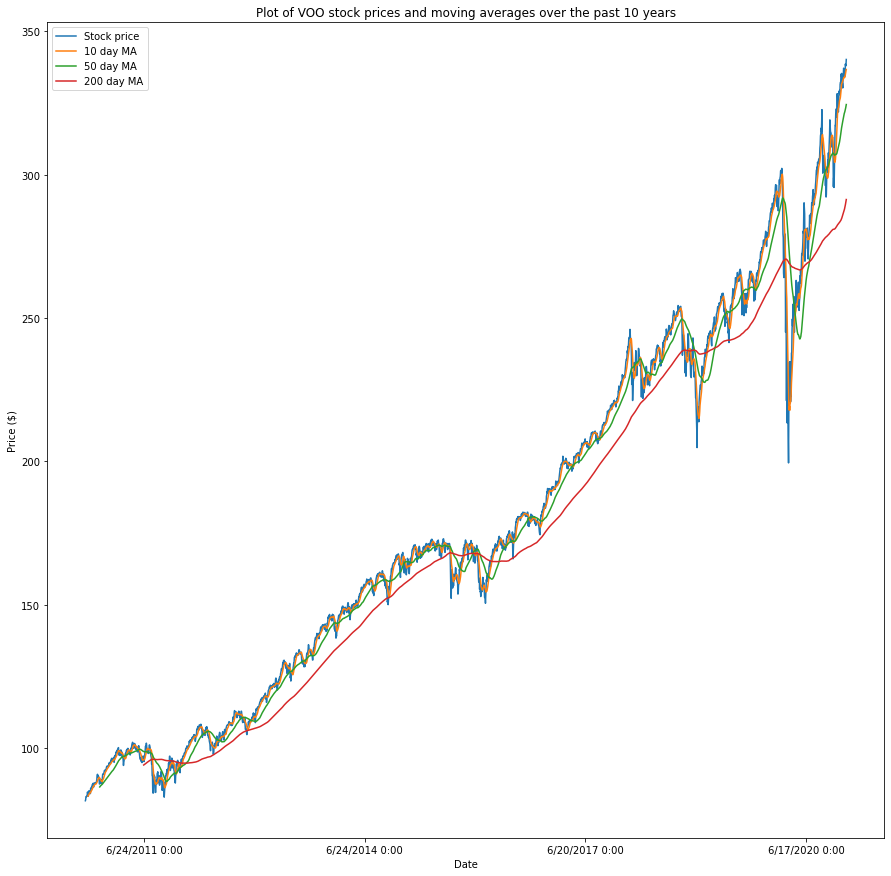

In [106]:
#ax = plt.plot(df['Date'], voo_stock_prices, label = "Stock prices")
#plt.locator_params(axis="x", nbins=5)
#ax.set_xticks(4)

fig, axes = plt.subplots(1,1)
axes.plot(df['Date'], voo_stock_prices)
axes.plot(df['Date'], voo_10day_ma)
axes.plot(df['Date'], voo_50day_ma)
axes.plot(df['Date'], voo_200day_ma)


axes.set_title("Plot of VOO stock prices and moving averages over the past 10 years")
axes.legend(["Stock price", "10 day MA", "50 day MA", "200 day MA"])
axes.xaxis.set_label_text("Date")
axes.yaxis.set_label_text("Price ($)")

axes.set_xticks([200, 953, 1706, 2459]) #adjusts the number of ticks (dates displayed on x axis)
fig.set_figheight(15)
fig.set_figwidth(15)

Notice that the 10 day moving average is the closest to the actual stock price. This makes sense, as the previous ten days are more relevant to the current day compared to the previous 50 or 200. 

Now I am going to make the training and prediction data for Ridge Regression. We will be predicting the price of a stock in 30 days. X will be the set of moving averages, and y will be the set of actual stock prices. We will train on the first 80% of the data and test on the final 20%. 

In [107]:
predict_days = 30
voo_prediction = voo_stock_prices.shift(-predict_days)
X = np.stack((voo_10day_ma[199:], voo_50day_ma[199:], voo_200day_ma[199:]), axis=1) #we do this so there are no nan values. index 199 is where 200day_ma starts
print("Notice how X changes")
print(X.shape)
X = X[:-predict_days]
print(X.shape)

y = voo_prediction[199:] #X and y need to have the same number of rows, so we also start at index 199
print("Notice how y changes")
print(y.shape)
y = y[:-predict_days]
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(" xtrain, y train, xtest, ytest")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


Notice how X changes
(2398, 3)
(2368, 3)
Notice how y changes
(2398,)
(2368,)
 xtrain, y train, xtest, ytest
(1894, 3)
(1894,)
(474, 3)
(474,)


Here is where we will apply ridge regression:

In [112]:
ridge_regression = Ridge()
ridge_regression.fit(X_train, y_train)
ridge_regression_score = ridge_regression.score(X_test, y_test)
print(ridge_regression_score)
print("i think this means how good the prediction is, but a value close to 1 is good")

X_pred = np.stack((voo_10day_ma[199:], voo_50day_ma[199:], voo_200day_ma[199:]), axis=1)
X_pred = X_pred[-predict_days:]
predict_prediction = ridge_regression.predict(X_pred)
real_prediction = ridge_regression.predict(np.stack((voo_10day_ma[199:], voo_50day_ma[199:], voo_200day_ma[199:]), axis=1))

print(df['Date'].shape)
print(voo_stock_prices.shape)
print(predict_prediction.shape) #notice how this is the same shape as the number of days we are trying to predict in the future
print(real_prediction.shape)
print(predict_prediction)
print(real_prediction[-predict_days:])
print(X_pred.shape)

0.9719218449702393
i think this means how good the prediction is, but a value close to 1 is good
(2597,)
(2597,)
(30,)
(2398,)
[315.16580115 315.60561076 315.90505408 316.0684246  316.62736964
 316.97725941 317.59038385 317.77439202 317.91354213 318.22721669
 318.78217816 319.45102358 320.28447406 321.10036391 321.33641559
 321.64787229 321.87794251 322.05989924 322.34862942 322.56794648
 322.97422369 323.1128437  323.29859109 323.36019939 323.67764779
 324.15708084 324.80451036 325.59229839 326.02323249 326.58577814]
[315.16580115 315.60561076 315.90505408 316.0684246  316.62736964
 316.97725941 317.59038385 317.77439202 317.91354213 318.22721669
 318.78217816 319.45102358 320.28447406 321.10036391 321.33641559
 321.64787229 321.87794251 322.05989924 322.34862942 322.56794648
 322.97422369 323.1128437  323.29859109 323.36019939 323.67764779
 324.15708084 324.80451036 325.59229839 326.02323249 326.58577814]
(30, 3)


(2597,)
(30,)
(2398,)


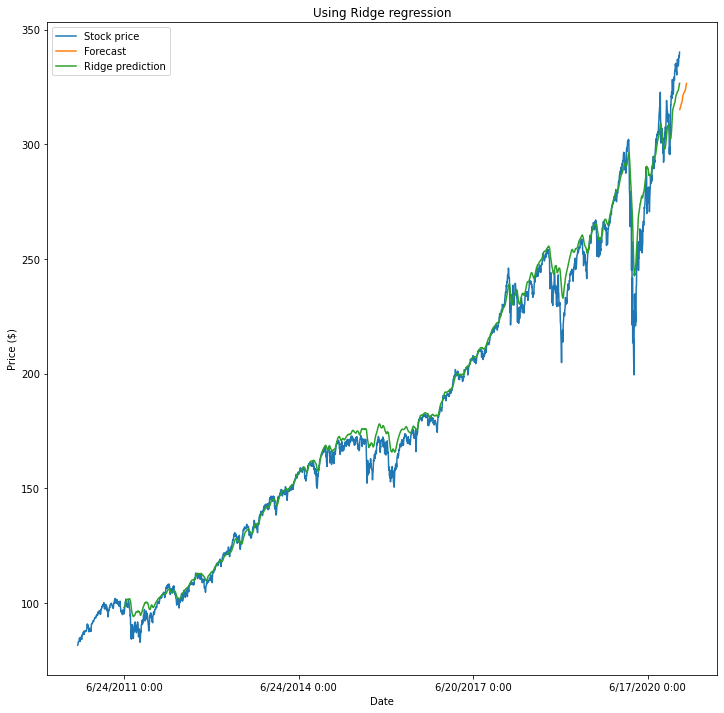

In [114]:
predicted_dates = [] #this is for calculating the predicted dates in the future
for i in range(predict_days):
    date = (datetime.strptime(df['Date'][2596], '%m/%d/%Y %H:%M') + timedelta(days=i + 1)).strftime('%m/%d/%Y %H:%M')
    predicted_dates.append(date)
predicted_dates = np.asarray(predicted_dates)

fig, axes = plt.subplots(1,1)
axes.plot(df['Date'], voo_stock_prices)
axes.plot(predicted_dates, predict_prediction)
axes.plot(df['Date'][199:], real_prediction)
print(voo_stock_prices.shape)
print(predict_prediction.shape)
print(real_prediction.shape)



axes.set_title("Using Ridge regression")
axes.legend(["Stock price", "Forecast", "Ridge prediction"])
axes.xaxis.set_label_text("Date")
axes.yaxis.set_label_text("Price ($)")

axes.set_xticks([200, 953, 1706, 2459]) #adjusts the number of ticks (dates displayed on x axis)
fig.set_figheight(12)
fig.set_figwidth(12)


Below I will make a more generalized function so that the number of days to predict and the stock abbreviation are the only parameters

Notice how X changes
r value
0.8472658439368418


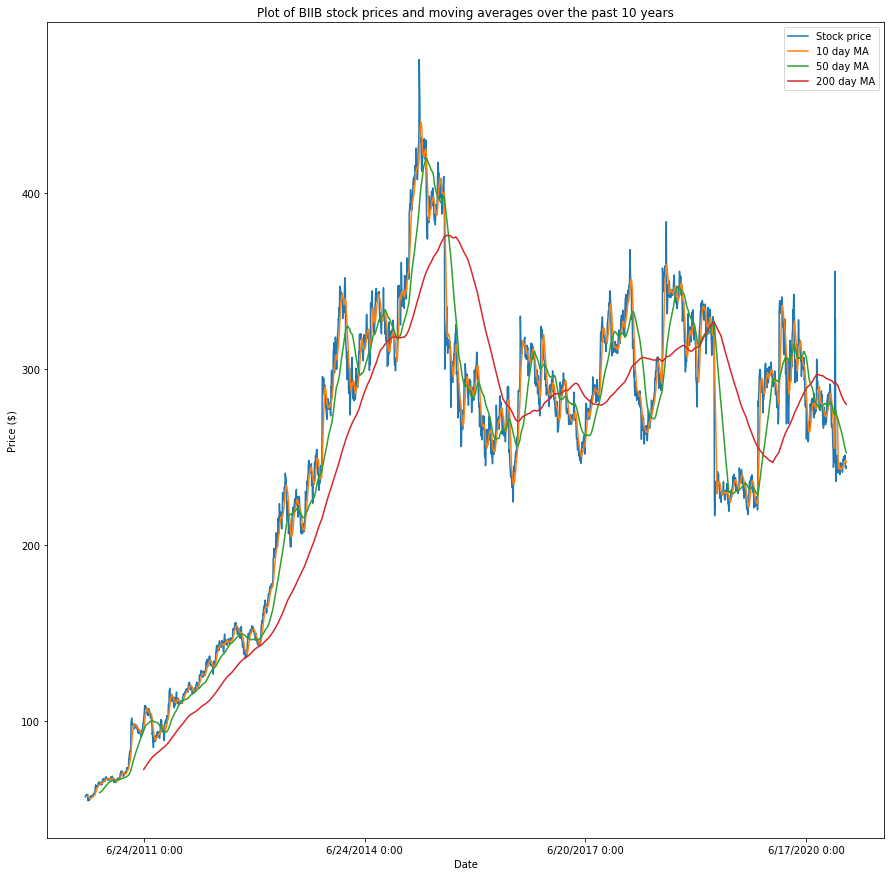

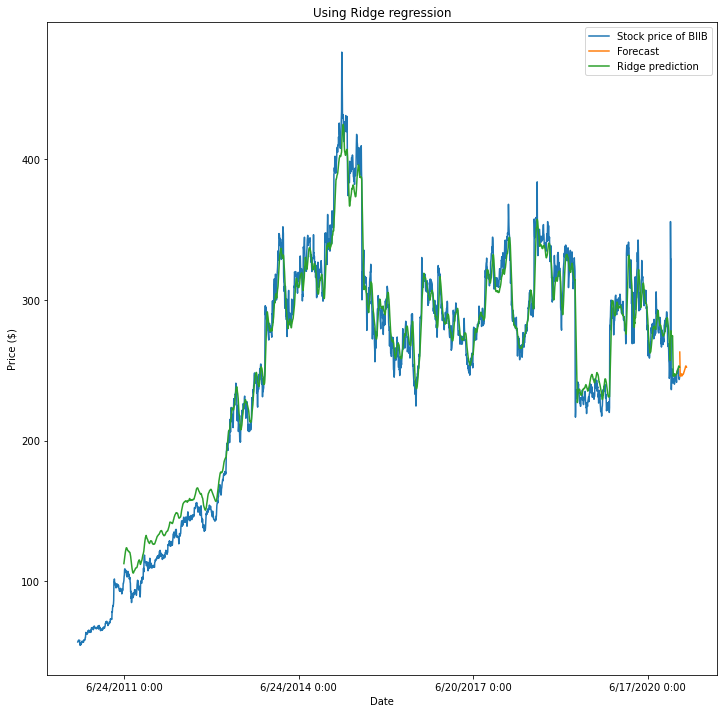

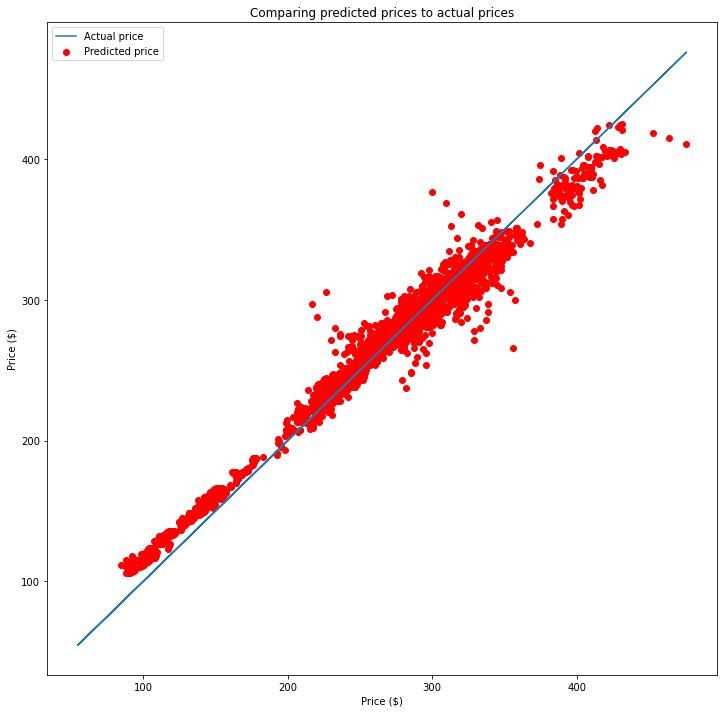

In [124]:
def ridge_prediction(stock, num_days=30):
    df = pd.read_csv('moving_average_plus_returns.csv')
    stock_prices = df[stock]
    _10day_ma = df[stock + '_10day_MA']
    _50day_ma = df[stock+ '_50day_MA']
    _200day_ma = df[stock+ '_200day_MA']
    _5day_mr = df[stock+ '_5day_mvg_return']
    _20day_mr = df[stock+ '_20day_mvg_return']
    _260day_mr = df[stock+ '_260day_mvg_return']
    ### plotting moving averages
    fig, axes = plt.subplots(1,1)
    axes.plot(df['Date'], stock_prices)
    axes.plot(df['Date'], _10day_ma)
    axes.plot(df['Date'], _50day_ma)
    axes.plot(df['Date'], _200day_ma)
    axes.set_title("Plot of " + stock + " stock prices and moving averages over the past 10 years")
    axes.legend(["Stock price", "10 day MA", "50 day MA", "200 day MA"])
    axes.xaxis.set_label_text("Date")
    axes.yaxis.set_label_text("Price ($)")

    axes.set_xticks([200, 953, 1706, 2459]) #adjusts the number of ticks (dates displayed on x axis)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ### end of plotting moving averages


    ###start of applying ridge regression
    stock_prediction = stock_prices.shift(-num_days)
    X = np.stack((_10day_ma[199:], _50day_ma[199:], _200day_ma[199:]), axis=1) #we do this so there are no nan values. index 199 is where 200day_ma starts
    print("Notice how X changes")
    X = X[:-num_days]

    y = stock_prediction[199:] #X and y need to have the same number of rows, so we also start at index 199
    y = y[:-num_days]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    ridge_regression = Ridge()
    ridge_regression.fit(X_train, y_train)
    ridge_regression_score = ridge_regression.score(X_test, y_test)
    print("r value")
    print(ridge_regression_score)

    X_pred = np.stack((_10day_ma[199:], _50day_ma[199:], _200day_ma[199:]), axis=1)
    X_pred = X_pred[-num_days:]
    predict_prediction = ridge_regression.predict(X_pred)
    real_prediction = ridge_regression.predict(np.stack((_10day_ma[199:], _50day_ma[199:], _200day_ma[199:]), axis=1))


    predicted_dates = [] #this is for calculating the predicted dates in the future
    for i in range(num_days):
        date = (datetime.strptime(df['Date'][2596], '%m/%d/%Y %H:%M') + timedelta(days=i + 1)).strftime('%m/%d/%Y %H:%M')
        predicted_dates.append(date)
    predicted_dates = np.asarray(predicted_dates)


    ##plotting the model
    fig, axes = plt.subplots(1,1)
    axes.plot(df['Date'], stock_prices)
    axes.plot(predicted_dates, predict_prediction)
    axes.plot(df['Date'][199:], real_prediction)



    axes.set_title("Using Ridge regression")
    axes.legend(["Stock price of " + stock, "Forecast", "Ridge prediction"])
    axes.xaxis.set_label_text("Date")
    axes.yaxis.set_label_text("Price ($)")

    axes.set_xticks([200, 953, 1706, 2459]) #adjusts the number of ticks (dates displayed on x axis)
    fig.set_figheight(12)
    fig.set_figwidth(12)

    ####plot to compare the predicted data points to the actual stock prices
    fig2, axes2 = plt.subplots(1,1)
    axes2.plot(stock_prices, stock_prices)
    axes2.scatter(stock_prices[199:],real_prediction,  color="red")
    axes2.set_title("Comparing predicted prices to actual prices")
    axes2.legend(["Actual price", "Predicted price"])
    axes2.yaxis.set_label_text("Price ($)")
    axes2.xaxis.set_label_text("Price ($)")
    fig2.set_figheight(12)
    fig2.set_figwidth(12)



#### Here is where you can run the function
ridge_prediction('BIIB') #pass in the stock abreviation and number of days to predict. The default number of days is 30